# DNN: analysis with Keras of 2D data

2
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 1.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 1.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 1.0
[14.24753279 21.74536208] 0.0
data: 4000
train: 3200
Train: 3200 	 Validation: 800


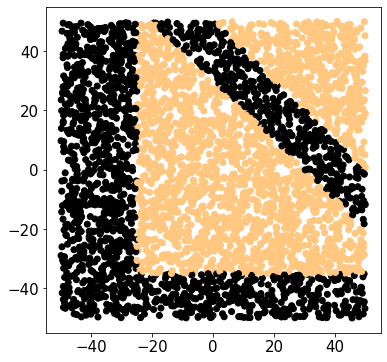

In [16]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.optimizers as opt

import matplotlib as mpl
mpl.rc('image', cmap='copper')
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 15

%run nonlinear_function.py

# training data
perc_train = 0.8

# Keras works with numpy arrays: just use them from the start
TYPE=1
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(L)

for i in range(10):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (6,6))
plt.scatter(x[:,0],x[:,1],c=y)
#plt.show()

(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

In [2]:
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

CASE=1

jvals=[10**i for i in range(-1, -5, -1)]
optimizers=[opt.Adam, opt.RMSprop, opt.Nadam, opt.Adamax]
rates=[10**i for i in range(-2, -5, -1)]

fits={}

for o in optimizers:
    fits[str(o)]={}
    for r in rates:
        fits[str(o)][str(r)]={}
        for j in jvals:
            print(j)
            model = Sequential()
            model.add(Dense(L,input_shape=(L,),activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dropout(j))
            model.add(Dense(1,activation='sigmoid'))
            nepoch=400
            #print(model.summary())
            model.compile(loss='binary_crossentropy',
                          optimizer=o(learning_rate=r),
                          metrics=['accuracy'])
            fit = model.fit(x_train, y_train,
                            epochs = nepoch, batch_size = 50,
                            validation_data=(x_valid,y_valid),
                            verbose=0)
            fits[str(o)][str(r)][str(j)]=fit

0.1


2023-03-06 10:58:58.275591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.01
0.001
0.0001
0.1


KeyboardInterrupt: 

In [ ]:
losses=[[[fits[i][j][k].history['val_loss'][-1] for k in fits[i][j]] for j in fits[i]] for i in fits]
accs=[[[fits[i][j][k].history["val_accuracy"][-1] for k in fits[i][j]] for j in fits[i]] for i in fits]
#print(losses)
m=np.min(losses)
a=np.max(accs)
f=False
for i in range(len(losses)):
    for j in range(len(losses[i])):
        for k in range(len(losses[i][j])):
            if m==losses[i][j][k]:
                print(i,j,k,m)
                f=True
                break
        if f:
            break
    if f:
        break

f=False
for i in range(len(losses)):
    for j in range(len(losses[i])):
        for k in range(len(losses[i][j])):
            if a==accs[i][j][k]:
                print(i,j,k,a)
                f=True
                break
        if f:
            break
    if f:
        break

### best is Nadam, rate 0.01, dropout 0.001

In [ ]:
import pandas as pd
import seaborn as sn 
fig, ax = plt.subplots(ncols=len(optimizers), nrows=2, figsize=(15,3) )
c=0
for o in range(len(optimizers)):
    df = pd.DataFrame(losses[o], index = [i for i in rates],
                  columns = [j for j in jvals])
    sn.heatmap(df, annot=True, cmap="Blues", ax=ax[0][o])
    df2 = pd.DataFrame(accs[o], index = [i for i in rates],
                  columns = [j for j in jvals])
    sn.heatmap(df2, annot=True, cmap="Blues", ax=ax[1][o])

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# define the neural network model
def create_model(L):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.001))
    model.add(Dense(1,activation='sigmoid'))
    optimizer = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# load your data and split it into training and testing sets
# X_train, y_train, X_test, y_test = ...

# set the number of epochs
nepoch = 1000

# define the range of percentages to use for training
percentages = np.arange(0.1, 1.1, 0.1)

# initialize an array to store the accuracies for each percentage
accuracies = np.zeros_like(percentages)

# loop over the percentages and train the model on the corresponding fraction of the data
for i, percentage in enumerate(percentages):
    # calculate the number of samples to use for training
    n_train = int(percentage * len(x_train))
    
    # split the data into training and validation sets
    X_train_partial = x_train[:n_train]
    y_train_partial = y_train[:n_train]
    
    # create the model
    model = create_model(L)
    
    # train the model on the training set
    history = model.fit(X_train_partial, y_train_partial, epochs=nepoch, batch_size=128, validation_data=(x_valid, y_valid), verbose=0)
    
    # evaluate the model on the testing set
    loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)
    accuracies[i] = accuracy
    print("Percentage of data used for training: {:.1f}%".format(percentage * 100))
    print("Accuracy on testing set: {:.2f}%\n".format(accuracy * 100))


Percentage of data used for training: 10.0%
Accuracy on testing set: 86.62%

Percentage of data used for training: 20.0%
Accuracy on testing set: 87.00%

Percentage of data used for training: 30.0%
Accuracy on testing set: 80.75%

Percentage of data used for training: 40.0%
Accuracy on testing set: 98.50%

Percentage of data used for training: 50.0%
Accuracy on testing set: 98.87%

Percentage of data used for training: 60.0%
Accuracy on testing set: 89.25%

Percentage of data used for training: 70.0%
Accuracy on testing set: 98.00%

Percentage of data used for training: 80.0%
Accuracy on testing set: 91.25%

Percentage of data used for training: 90.0%
Accuracy on testing set: 98.62%



## Augmenting data
When deciding the method to employ in order to augment data special attention was given over how to treat the boundaries, three options came to mind:

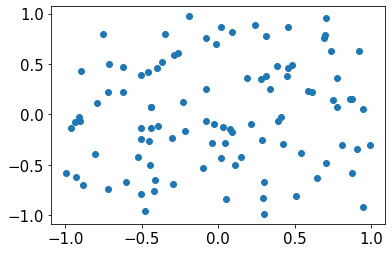

In [63]:
#import necessary libraries and create dummy dataset
import numpy.random as npr
N = 100
data = 2*npr.rand(2,N)-1
plt.scatter(data[1],data[0])
plt.show()

1) simply adding random noise

Easy to implement but the training region will end up being bigger than the validation (and original data) region

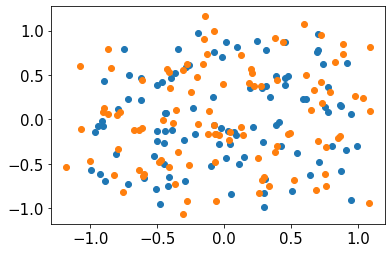

In [64]:
alpha = 0.2
data_aug = data + alpha*(2*npr.rand(2,N)-1)
plt.scatter(data[1],data[0])
plt.scatter(data_aug[1],data_aug[0])
plt.show()

2) adding random noise and truncate the new data to be inside the original boundaries

Also easy to implement via a mask but the augmented data density will be lower along the borders of the dataset due to the possible rejection of newly generated points

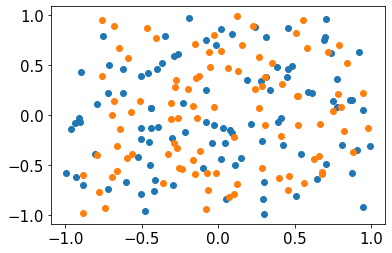

In [65]:
data_aug = data + alpha*(2*npr.rand(2,N)-1)

# Boolean mask to remove points outside of [-1,1] in x or y coordinate
mask = (np.abs(data_aug[0]) <= 1) & (np.abs(data_aug[1]) <= 1)
data_aug = data_aug[:, mask]


plt.scatter(data[1],data[0])
plt.scatter(data_aug[0], data_aug[1])
plt.show()

3) adding random noise and treat the boundaries as a sort of "wall" on which points outside the boundary reflect, for example if x_generated=1.03 the final x_fixed=0.97 as if it reflected along the boundary

Slightly more difficult to implement but it should solve both the issues found in the previous methods

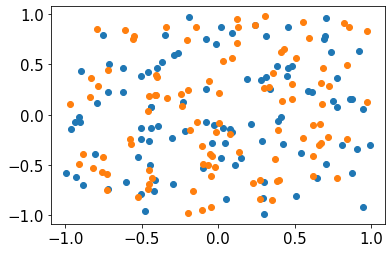

In [66]:
data_aug = data + alpha*(2*npr.rand(2,N)-1)

# reflect points outside of [-1,1] in x or y coordinate
data_aug[0] = np.where(np.abs(data_aug[0]) <= 1, data_aug[0], np.sign(data_aug[0]) * (2 - np.abs(data_aug[0])))
data_aug[1] = np.where(np.abs(data_aug[1]) <= 1, data_aug[1], np.sign(data_aug[1]) * (2 - np.abs(data_aug[1])))


plt.scatter(data[1],data[0])
plt.scatter(data_aug[0], data_aug[1])
plt.show()

Let's now implement the augmentation on the dataset

(6400, 2) (6400,)
(9600, 2) (9600,)


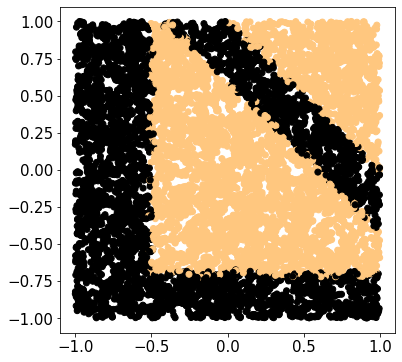

In [83]:
N_aug=2 #number of copies of the data to be augmented
alpha=0.03 #seems a reasonable quantity
x_aug=x_train
y_aug=y_train
for i in range (0,N_aug):
    data_aug_x = x_train + alpha*(2*npr.rand(N_train,2)-1)
    data_aug_x[:, 0] = np.where(np.abs(data_aug_x[:, 0]) <= 1, data_aug_x[:, 0], np.sign(data_aug_x[:, 0]) * (2 - np.abs(data_aug_x[:, 0])))
    data_aug_x[:, 1] = np.where(np.abs(data_aug_x[:, 1]) <= 1, data_aug_x[:, 1], np.sign(data_aug_x[:, 1]) * (2 - np.abs(data_aug_x[:, 1])))
    x_aug = np.concatenate((x_aug,data_aug_x),axis=0)
    y_aug = np.concatenate((y_aug,y_train))
    print(x_aug.shape,y_aug.shape)
    
plt.figure(figsize = (6,6))
plt.scatter(x_aug[:,0],x_aug[:,1],c=y_aug)
#plt.show()

Best architecture used previously is employed

In [84]:
            model = Sequential()
            model.add(Dense(L,input_shape=(L,),activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dense(20,activation='relu'))
            model.add(Dropout(0.001))
            model.add(Dense(1,activation='sigmoid'))
            nepoch=1000
            #print(model.summary())
            model.compile(loss='binary_crossentropy',
                          optimizer=opt.Nadam(learning_rate=0.01),
                          metrics=['accuracy'])
            fit = model.fit(x_aug, y_aug,
                            epochs = nepoch, batch_size = 50,
                            validation_data=(x_valid,y_valid),
                            verbose=2)

Epoch 1/1000
192/192 - 1s - loss: 0.5331 - accuracy: 0.7216 - val_loss: 0.4575 - val_accuracy: 0.7638 - 876ms/epoch - 5ms/step
Epoch 2/1000
192/192 - 0s - loss: 0.3732 - accuracy: 0.8289 - val_loss: 0.2870 - val_accuracy: 0.8750 - 150ms/epoch - 782us/step
Epoch 3/1000
192/192 - 0s - loss: 0.3148 - accuracy: 0.8542 - val_loss: 0.2469 - val_accuracy: 0.8925 - 150ms/epoch - 782us/step
Epoch 4/1000
192/192 - 0s - loss: 0.2874 - accuracy: 0.8575 - val_loss: 0.2401 - val_accuracy: 0.8813 - 165ms/epoch - 857us/step
Epoch 5/1000
192/192 - 0s - loss: 0.2732 - accuracy: 0.8625 - val_loss: 0.2401 - val_accuracy: 0.8700 - 147ms/epoch - 767us/step
Epoch 6/1000
192/192 - 0s - loss: 0.2717 - accuracy: 0.8623 - val_loss: 0.2333 - val_accuracy: 0.8863 - 147ms/epoch - 763us/step
Epoch 7/1000
192/192 - 0s - loss: 0.2670 - accuracy: 0.8642 - val_loss: 0.2185 - val_accuracy: 0.8913 - 156ms/epoch - 811us/step
Epoch 8/1000
192/192 - 0s - loss: 0.2670 - accuracy: 0.8655 - val_loss: 0.2580 - val_accuracy: 0.87

192/192 - 0s - loss: 0.0715 - accuracy: 0.9694 - val_loss: 0.0647 - val_accuracy: 0.9737 - 163ms/epoch - 847us/step
Epoch 65/1000
192/192 - 0s - loss: 0.0701 - accuracy: 0.9702 - val_loss: 0.1032 - val_accuracy: 0.9625 - 159ms/epoch - 829us/step
Epoch 66/1000
192/192 - 0s - loss: 0.0715 - accuracy: 0.9694 - val_loss: 0.0396 - val_accuracy: 0.9887 - 157ms/epoch - 820us/step
Epoch 67/1000
192/192 - 0s - loss: 0.0697 - accuracy: 0.9703 - val_loss: 0.0565 - val_accuracy: 0.9712 - 159ms/epoch - 827us/step
Epoch 68/1000
192/192 - 0s - loss: 0.0726 - accuracy: 0.9698 - val_loss: 0.0486 - val_accuracy: 0.9762 - 157ms/epoch - 816us/step
Epoch 69/1000
192/192 - 0s - loss: 0.0724 - accuracy: 0.9690 - val_loss: 0.0487 - val_accuracy: 0.9787 - 157ms/epoch - 817us/step
Epoch 70/1000
192/192 - 0s - loss: 0.0711 - accuracy: 0.9682 - val_loss: 0.0646 - val_accuracy: 0.9712 - 155ms/epoch - 807us/step
Epoch 71/1000
192/192 - 0s - loss: 0.0679 - accuracy: 0.9712 - val_loss: 0.0828 - val_accuracy: 0.9638 -

Epoch 127/1000
192/192 - 0s - loss: 0.0644 - accuracy: 0.9740 - val_loss: 0.0418 - val_accuracy: 0.9825 - 150ms/epoch - 779us/step
Epoch 128/1000
192/192 - 0s - loss: 0.0675 - accuracy: 0.9705 - val_loss: 0.0506 - val_accuracy: 0.9787 - 153ms/epoch - 796us/step
Epoch 129/1000
192/192 - 0s - loss: 0.0646 - accuracy: 0.9711 - val_loss: 0.0616 - val_accuracy: 0.9700 - 148ms/epoch - 772us/step
Epoch 130/1000
192/192 - 0s - loss: 0.0690 - accuracy: 0.9704 - val_loss: 0.0612 - val_accuracy: 0.9675 - 153ms/epoch - 798us/step
Epoch 131/1000
192/192 - 0s - loss: 0.0704 - accuracy: 0.9711 - val_loss: 0.0433 - val_accuracy: 0.9800 - 150ms/epoch - 781us/step
Epoch 132/1000
192/192 - 0s - loss: 0.0645 - accuracy: 0.9725 - val_loss: 0.0418 - val_accuracy: 0.9887 - 181ms/epoch - 940us/step
Epoch 133/1000
192/192 - 0s - loss: 0.0679 - accuracy: 0.9707 - val_loss: 0.0568 - val_accuracy: 0.9725 - 166ms/epoch - 862us/step
Epoch 134/1000
192/192 - 0s - loss: 0.0650 - accuracy: 0.9719 - val_loss: 0.0373 - 

Epoch 190/1000
192/192 - 0s - loss: 0.0653 - accuracy: 0.9692 - val_loss: 0.0551 - val_accuracy: 0.9750 - 152ms/epoch - 793us/step
Epoch 191/1000
192/192 - 0s - loss: 0.0655 - accuracy: 0.9696 - val_loss: 0.0575 - val_accuracy: 0.9775 - 145ms/epoch - 757us/step
Epoch 192/1000
192/192 - 0s - loss: 0.0650 - accuracy: 0.9722 - val_loss: 0.0774 - val_accuracy: 0.9650 - 145ms/epoch - 757us/step
Epoch 193/1000
192/192 - 0s - loss: 0.0662 - accuracy: 0.9732 - val_loss: 0.0445 - val_accuracy: 0.9837 - 146ms/epoch - 759us/step
Epoch 194/1000
192/192 - 0s - loss: 0.0640 - accuracy: 0.9739 - val_loss: 0.0500 - val_accuracy: 0.9737 - 146ms/epoch - 762us/step
Epoch 195/1000
192/192 - 0s - loss: 0.0648 - accuracy: 0.9716 - val_loss: 0.0793 - val_accuracy: 0.9663 - 146ms/epoch - 758us/step
Epoch 196/1000
192/192 - 0s - loss: 0.0695 - accuracy: 0.9693 - val_loss: 0.0392 - val_accuracy: 0.9912 - 145ms/epoch - 756us/step
Epoch 197/1000
192/192 - 0s - loss: 0.0655 - accuracy: 0.9706 - val_loss: 0.0366 - 

Epoch 253/1000
192/192 - 0s - loss: 0.0661 - accuracy: 0.9721 - val_loss: 0.0550 - val_accuracy: 0.9750 - 144ms/epoch - 749us/step
Epoch 254/1000
192/192 - 0s - loss: 0.0649 - accuracy: 0.9710 - val_loss: 0.0670 - val_accuracy: 0.9700 - 143ms/epoch - 746us/step
Epoch 255/1000
192/192 - 0s - loss: 0.0656 - accuracy: 0.9702 - val_loss: 0.0384 - val_accuracy: 0.9837 - 144ms/epoch - 752us/step
Epoch 256/1000
192/192 - 0s - loss: 0.0616 - accuracy: 0.9743 - val_loss: 0.0379 - val_accuracy: 0.9862 - 144ms/epoch - 749us/step
Epoch 257/1000
192/192 - 0s - loss: 0.0620 - accuracy: 0.9740 - val_loss: 0.0461 - val_accuracy: 0.9762 - 144ms/epoch - 752us/step
Epoch 258/1000
192/192 - 0s - loss: 0.0628 - accuracy: 0.9723 - val_loss: 0.0420 - val_accuracy: 0.9787 - 144ms/epoch - 751us/step
Epoch 259/1000
192/192 - 0s - loss: 0.0703 - accuracy: 0.9701 - val_loss: 0.0352 - val_accuracy: 0.9900 - 144ms/epoch - 753us/step
Epoch 260/1000
192/192 - 0s - loss: 0.0610 - accuracy: 0.9740 - val_loss: 0.0433 - 

Epoch 316/1000
192/192 - 0s - loss: 0.0587 - accuracy: 0.9751 - val_loss: 0.0423 - val_accuracy: 0.9762 - 145ms/epoch - 756us/step
Epoch 317/1000
192/192 - 0s - loss: 0.0697 - accuracy: 0.9718 - val_loss: 0.0619 - val_accuracy: 0.9800 - 144ms/epoch - 750us/step
Epoch 318/1000
192/192 - 0s - loss: 0.0636 - accuracy: 0.9730 - val_loss: 0.0410 - val_accuracy: 0.9825 - 144ms/epoch - 751us/step
Epoch 319/1000
192/192 - 0s - loss: 0.0643 - accuracy: 0.9723 - val_loss: 0.0483 - val_accuracy: 0.9812 - 145ms/epoch - 754us/step
Epoch 320/1000
192/192 - 0s - loss: 0.0585 - accuracy: 0.9753 - val_loss: 0.0417 - val_accuracy: 0.9862 - 144ms/epoch - 751us/step
Epoch 321/1000
192/192 - 0s - loss: 0.0641 - accuracy: 0.9727 - val_loss: 0.0445 - val_accuracy: 0.9787 - 144ms/epoch - 748us/step
Epoch 322/1000
192/192 - 0s - loss: 0.0626 - accuracy: 0.9736 - val_loss: 0.0705 - val_accuracy: 0.9688 - 145ms/epoch - 753us/step
Epoch 323/1000
192/192 - 0s - loss: 0.0616 - accuracy: 0.9730 - val_loss: 0.0411 - 

Epoch 379/1000
192/192 - 0s - loss: 0.0645 - accuracy: 0.9712 - val_loss: 0.0720 - val_accuracy: 0.9700 - 160ms/epoch - 833us/step
Epoch 380/1000
192/192 - 0s - loss: 0.0618 - accuracy: 0.9737 - val_loss: 0.0530 - val_accuracy: 0.9725 - 148ms/epoch - 772us/step
Epoch 381/1000
192/192 - 0s - loss: 0.0631 - accuracy: 0.9732 - val_loss: 0.0755 - val_accuracy: 0.9688 - 154ms/epoch - 801us/step
Epoch 382/1000
192/192 - 0s - loss: 0.0619 - accuracy: 0.9730 - val_loss: 0.0388 - val_accuracy: 0.9775 - 149ms/epoch - 774us/step
Epoch 383/1000
192/192 - 0s - loss: 0.0626 - accuracy: 0.9718 - val_loss: 0.0383 - val_accuracy: 0.9875 - 151ms/epoch - 786us/step
Epoch 384/1000
192/192 - 0s - loss: 0.0602 - accuracy: 0.9732 - val_loss: 0.0412 - val_accuracy: 0.9837 - 152ms/epoch - 791us/step
Epoch 385/1000
192/192 - 0s - loss: 0.0685 - accuracy: 0.9715 - val_loss: 0.0471 - val_accuracy: 0.9837 - 152ms/epoch - 791us/step
Epoch 386/1000
192/192 - 0s - loss: 0.0624 - accuracy: 0.9714 - val_loss: 0.0351 - 

Epoch 442/1000
192/192 - 0s - loss: 0.0586 - accuracy: 0.9732 - val_loss: 0.0390 - val_accuracy: 0.9825 - 145ms/epoch - 756us/step
Epoch 443/1000
192/192 - 0s - loss: 0.0602 - accuracy: 0.9726 - val_loss: 0.0393 - val_accuracy: 0.9850 - 145ms/epoch - 754us/step
Epoch 444/1000
192/192 - 0s - loss: 0.0602 - accuracy: 0.9737 - val_loss: 0.0530 - val_accuracy: 0.9725 - 144ms/epoch - 749us/step
Epoch 445/1000
192/192 - 0s - loss: 0.0687 - accuracy: 0.9716 - val_loss: 0.0682 - val_accuracy: 0.9712 - 143ms/epoch - 747us/step
Epoch 446/1000
192/192 - 0s - loss: 0.0645 - accuracy: 0.9741 - val_loss: 0.0412 - val_accuracy: 0.9812 - 144ms/epoch - 751us/step
Epoch 447/1000
192/192 - 0s - loss: 0.0594 - accuracy: 0.9723 - val_loss: 0.0380 - val_accuracy: 0.9862 - 152ms/epoch - 791us/step
Epoch 448/1000
192/192 - 0s - loss: 0.0599 - accuracy: 0.9745 - val_loss: 0.0727 - val_accuracy: 0.9638 - 146ms/epoch - 762us/step
Epoch 449/1000
192/192 - 0s - loss: 0.0619 - accuracy: 0.9735 - val_loss: 0.0673 - 

Epoch 505/1000
192/192 - 0s - loss: 0.0598 - accuracy: 0.9731 - val_loss: 0.0446 - val_accuracy: 0.9787 - 146ms/epoch - 760us/step
Epoch 506/1000
192/192 - 0s - loss: 0.0621 - accuracy: 0.9735 - val_loss: 0.0461 - val_accuracy: 0.9737 - 147ms/epoch - 765us/step
Epoch 507/1000
192/192 - 0s - loss: 0.0604 - accuracy: 0.9740 - val_loss: 0.0411 - val_accuracy: 0.9812 - 146ms/epoch - 759us/step
Epoch 508/1000
192/192 - 0s - loss: 0.0682 - accuracy: 0.9716 - val_loss: 0.0373 - val_accuracy: 0.9850 - 226ms/epoch - 1ms/step
Epoch 509/1000
192/192 - 0s - loss: 0.0574 - accuracy: 0.9746 - val_loss: 0.0533 - val_accuracy: 0.9737 - 217ms/epoch - 1ms/step
Epoch 510/1000
192/192 - 0s - loss: 0.0588 - accuracy: 0.9743 - val_loss: 0.0346 - val_accuracy: 0.9887 - 179ms/epoch - 933us/step
Epoch 511/1000
192/192 - 0s - loss: 0.0621 - accuracy: 0.9736 - val_loss: 0.0431 - val_accuracy: 0.9762 - 173ms/epoch - 902us/step
Epoch 512/1000
192/192 - 0s - loss: 0.0637 - accuracy: 0.9727 - val_loss: 0.1523 - val_

Epoch 568/1000
192/192 - 0s - loss: 0.0567 - accuracy: 0.9756 - val_loss: 0.0445 - val_accuracy: 0.9787 - 260ms/epoch - 1ms/step
Epoch 569/1000
192/192 - 0s - loss: 0.0587 - accuracy: 0.9753 - val_loss: 0.0499 - val_accuracy: 0.9737 - 173ms/epoch - 903us/step
Epoch 570/1000
192/192 - 0s - loss: 0.0582 - accuracy: 0.9746 - val_loss: 0.0487 - val_accuracy: 0.9750 - 160ms/epoch - 834us/step
Epoch 571/1000
192/192 - 0s - loss: 0.0560 - accuracy: 0.9760 - val_loss: 0.0335 - val_accuracy: 0.9862 - 302ms/epoch - 2ms/step
Epoch 572/1000
192/192 - 0s - loss: 0.0625 - accuracy: 0.9730 - val_loss: 0.1040 - val_accuracy: 0.9588 - 147ms/epoch - 766us/step
Epoch 573/1000
192/192 - 0s - loss: 0.0708 - accuracy: 0.9692 - val_loss: 0.0387 - val_accuracy: 0.9837 - 145ms/epoch - 757us/step
Epoch 574/1000
192/192 - 0s - loss: 0.0624 - accuracy: 0.9726 - val_loss: 0.0355 - val_accuracy: 0.9812 - 185ms/epoch - 961us/step
Epoch 575/1000
192/192 - 0s - loss: 0.0574 - accuracy: 0.9742 - val_loss: 0.0475 - val_

Epoch 631/1000
192/192 - 0s - loss: 0.0560 - accuracy: 0.9744 - val_loss: 0.0383 - val_accuracy: 0.9837 - 143ms/epoch - 746us/step
Epoch 632/1000
192/192 - 0s - loss: 0.0581 - accuracy: 0.9751 - val_loss: 0.0443 - val_accuracy: 0.9800 - 144ms/epoch - 748us/step
Epoch 633/1000
192/192 - 0s - loss: 0.0650 - accuracy: 0.9724 - val_loss: 0.0369 - val_accuracy: 0.9850 - 144ms/epoch - 750us/step
Epoch 634/1000
192/192 - 0s - loss: 0.0623 - accuracy: 0.9718 - val_loss: 0.0370 - val_accuracy: 0.9900 - 143ms/epoch - 746us/step
Epoch 635/1000
192/192 - 0s - loss: 0.0652 - accuracy: 0.9730 - val_loss: 0.0772 - val_accuracy: 0.9663 - 153ms/epoch - 796us/step
Epoch 636/1000
192/192 - 0s - loss: 0.0710 - accuracy: 0.9716 - val_loss: 0.0612 - val_accuracy: 0.9737 - 145ms/epoch - 756us/step
Epoch 637/1000
192/192 - 0s - loss: 0.0796 - accuracy: 0.9685 - val_loss: 0.0375 - val_accuracy: 0.9862 - 144ms/epoch - 749us/step
Epoch 638/1000
192/192 - 0s - loss: 0.0551 - accuracy: 0.9746 - val_loss: 0.0355 - 

Epoch 694/1000
192/192 - 0s - loss: 0.0569 - accuracy: 0.9746 - val_loss: 0.0443 - val_accuracy: 0.9775 - 143ms/epoch - 746us/step
Epoch 695/1000
192/192 - 0s - loss: 0.0581 - accuracy: 0.9736 - val_loss: 0.0443 - val_accuracy: 0.9800 - 143ms/epoch - 746us/step
Epoch 696/1000
192/192 - 0s - loss: 0.0627 - accuracy: 0.9739 - val_loss: 0.0507 - val_accuracy: 0.9825 - 151ms/epoch - 785us/step
Epoch 697/1000
192/192 - 0s - loss: 0.0575 - accuracy: 0.9746 - val_loss: 0.0339 - val_accuracy: 0.9850 - 149ms/epoch - 775us/step
Epoch 698/1000
192/192 - 0s - loss: 0.0623 - accuracy: 0.9733 - val_loss: 0.0299 - val_accuracy: 0.9962 - 152ms/epoch - 790us/step
Epoch 699/1000
192/192 - 0s - loss: 0.0598 - accuracy: 0.9741 - val_loss: 0.0413 - val_accuracy: 0.9812 - 145ms/epoch - 754us/step
Epoch 700/1000
192/192 - 0s - loss: 0.0596 - accuracy: 0.9746 - val_loss: 0.0571 - val_accuracy: 0.9775 - 143ms/epoch - 746us/step
Epoch 701/1000
192/192 - 0s - loss: 0.0640 - accuracy: 0.9748 - val_loss: 0.0328 - 

Epoch 757/1000
192/192 - 0s - loss: 0.0936 - accuracy: 0.9592 - val_loss: 0.0463 - val_accuracy: 0.9837 - 144ms/epoch - 752us/step
Epoch 758/1000
192/192 - 0s - loss: 0.0756 - accuracy: 0.9677 - val_loss: 0.4566 - val_accuracy: 0.9287 - 143ms/epoch - 745us/step
Epoch 759/1000
192/192 - 0s - loss: 0.0659 - accuracy: 0.9727 - val_loss: 0.0320 - val_accuracy: 0.9900 - 144ms/epoch - 749us/step
Epoch 760/1000
192/192 - 0s - loss: 0.0580 - accuracy: 0.9742 - val_loss: 0.0303 - val_accuracy: 0.9887 - 144ms/epoch - 749us/step
Epoch 761/1000
192/192 - 0s - loss: 0.0642 - accuracy: 0.9722 - val_loss: 0.0369 - val_accuracy: 0.9887 - 147ms/epoch - 767us/step
Epoch 762/1000
192/192 - 0s - loss: 0.0570 - accuracy: 0.9747 - val_loss: 0.0301 - val_accuracy: 0.9950 - 144ms/epoch - 748us/step
Epoch 763/1000
192/192 - 0s - loss: 0.0554 - accuracy: 0.9755 - val_loss: 0.0355 - val_accuracy: 0.9850 - 144ms/epoch - 750us/step
Epoch 764/1000
192/192 - 0s - loss: 0.0550 - accuracy: 0.9756 - val_loss: 0.0275 - 

Epoch 820/1000
192/192 - 0s - loss: 0.0542 - accuracy: 0.9760 - val_loss: 0.0289 - val_accuracy: 0.9937 - 144ms/epoch - 748us/step
Epoch 821/1000
192/192 - 0s - loss: 0.0568 - accuracy: 0.9761 - val_loss: 0.0405 - val_accuracy: 0.9862 - 144ms/epoch - 749us/step
Epoch 822/1000
192/192 - 0s - loss: 0.0662 - accuracy: 0.9718 - val_loss: 0.0320 - val_accuracy: 0.9887 - 144ms/epoch - 749us/step
Epoch 823/1000
192/192 - 0s - loss: 0.0547 - accuracy: 0.9760 - val_loss: 0.0313 - val_accuracy: 0.9875 - 143ms/epoch - 744us/step
Epoch 824/1000
192/192 - 0s - loss: 0.0547 - accuracy: 0.9764 - val_loss: 0.0519 - val_accuracy: 0.9750 - 143ms/epoch - 746us/step
Epoch 825/1000
192/192 - 0s - loss: 0.0547 - accuracy: 0.9746 - val_loss: 0.0301 - val_accuracy: 0.9900 - 144ms/epoch - 748us/step
Epoch 826/1000
192/192 - 0s - loss: 0.0776 - accuracy: 0.9720 - val_loss: 0.0317 - val_accuracy: 0.9862 - 143ms/epoch - 745us/step
Epoch 827/1000
192/192 - 0s - loss: 0.0593 - accuracy: 0.9742 - val_loss: 0.0483 - 

Epoch 883/1000
192/192 - 0s - loss: 0.0579 - accuracy: 0.9758 - val_loss: 0.0415 - val_accuracy: 0.9762 - 154ms/epoch - 803us/step
Epoch 884/1000
192/192 - 0s - loss: 0.0580 - accuracy: 0.9756 - val_loss: 0.0333 - val_accuracy: 0.9850 - 156ms/epoch - 814us/step
Epoch 885/1000
192/192 - 0s - loss: 0.0565 - accuracy: 0.9743 - val_loss: 0.0295 - val_accuracy: 0.9900 - 158ms/epoch - 825us/step
Epoch 886/1000
192/192 - 0s - loss: 0.0584 - accuracy: 0.9728 - val_loss: 0.0415 - val_accuracy: 0.9837 - 146ms/epoch - 761us/step
Epoch 887/1000
192/192 - 0s - loss: 0.0568 - accuracy: 0.9760 - val_loss: 0.0450 - val_accuracy: 0.9775 - 143ms/epoch - 745us/step
Epoch 888/1000
192/192 - 0s - loss: 0.0596 - accuracy: 0.9740 - val_loss: 0.0600 - val_accuracy: 0.9725 - 143ms/epoch - 747us/step
Epoch 889/1000
192/192 - 0s - loss: 0.1233 - accuracy: 0.9567 - val_loss: 0.0546 - val_accuracy: 0.9712 - 145ms/epoch - 754us/step
Epoch 890/1000
192/192 - 0s - loss: 0.0593 - accuracy: 0.9758 - val_loss: 0.0429 - 

Epoch 946/1000
192/192 - 0s - loss: 0.0562 - accuracy: 0.9737 - val_loss: 0.0532 - val_accuracy: 0.9837 - 143ms/epoch - 746us/step
Epoch 947/1000
192/192 - 0s - loss: 0.0586 - accuracy: 0.9748 - val_loss: 0.0407 - val_accuracy: 0.9837 - 143ms/epoch - 746us/step
Epoch 948/1000
192/192 - 0s - loss: 0.0549 - accuracy: 0.9744 - val_loss: 0.0263 - val_accuracy: 0.9937 - 144ms/epoch - 749us/step
Epoch 949/1000
192/192 - 0s - loss: 0.0556 - accuracy: 0.9761 - val_loss: 0.0430 - val_accuracy: 0.9800 - 143ms/epoch - 744us/step
Epoch 950/1000
192/192 - 0s - loss: 0.0549 - accuracy: 0.9761 - val_loss: 0.0351 - val_accuracy: 0.9850 - 144ms/epoch - 750us/step
Epoch 951/1000
192/192 - 0s - loss: 0.0862 - accuracy: 0.9654 - val_loss: 0.2712 - val_accuracy: 0.8550 - 144ms/epoch - 748us/step
Epoch 952/1000
192/192 - 0s - loss: 0.0758 - accuracy: 0.9671 - val_loss: 0.0344 - val_accuracy: 0.9862 - 143ms/epoch - 747us/step
Epoch 953/1000
192/192 - 0s - loss: 0.0607 - accuracy: 0.9749 - val_loss: 0.0367 - 

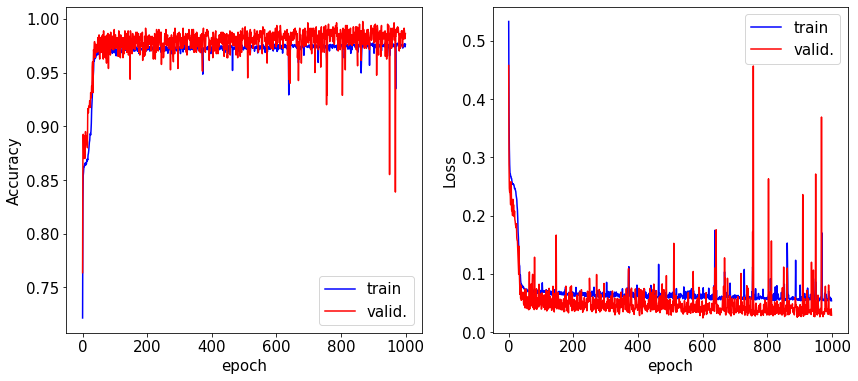

In [85]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [86]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model.predict(grid_r)

51 2601
[50. 50.]
82/82 [==============================] - 0s 419us/step


<function matplotlib.pyplot.show(close=None, block=None)>

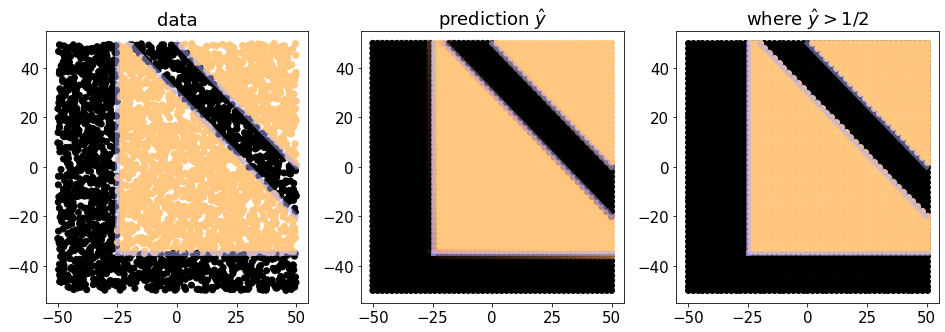

In [87]:
def boundaries():  
    x1=-25
    y1=-35
    c="#AAAAFF"
    a=0.5
    lw=5
    ax.plot((50,-20),(-20,50),c=c,alpha=a,lw=lw)
    ax.plot((50,0),(0,50),c=c,alpha=a,lw=lw)
    ax.plot((x1,50),(y1,y1),c=c,alpha=a,lw=lw)
    ax.plot((x1,x1),(y1,50),c=c,alpha=a,lw=lw)
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
boundaries()
ax.set_title("data")
ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
boundaries()
ax.set_title("prediction $\\hat y$")
ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#000000")
ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
boundaries()
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show

Testing with various amounts of noise ($0.01<\alpha<0.1$) shows that, while performance can be satisfying on the validation set it will never be as stable, reliable and efficient as just using original data. This is reasonable since random noise is, by definition, not learnable so at best we can achieve the same result as before.